# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2.Connect to Goole Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 3. Read the files with pandas

In [21]:
# Load the CSV files into pandas DataFrames

df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

## Step 1: Filter Data for the "Guayas" Region

In [4]:
# import pandas as pd

# # Step 1: Convert 'date' column to datetime format (outside the chunk loop for efficiency)
# df_stores['state'] = df_stores['state'].astype(str)  # Ensure 'state' column is of type str

# # Step 2: Get store_ids for the state 'Guayas'
# store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# # Step 3: Define the item families of interest
# item_families = ['GROCERY I', 'BEVERAGES', 'CLEANING']

# # Step 4: Initialize an empty list to hold filtered chunks
# filtered_chunks = []

# # Define chunk size (adjust based on system's memory capacity)
# chunk_size = 10 ** 6

# # Step 5: Read and filter the CSV file in chunks
# for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv',
#                          chunksize=chunk_size,
#                          parse_dates=['date'],
#                          dtype={'onpromotion': str}):
#     # Filter by store_nbr, date range, and item families in the chunk
#     chunk = chunk[(chunk['store_nbr'].isin(store_ids)) &
#                   (chunk['date'] >= '2014-01-01') &
#                   (chunk['date'] <= '2014-03-31')]

#     # Merge with df_items (we assume df_items is already loaded)
#     chunk = chunk.merge(df_items, on='item_nbr', how='left')

#     # Filter by item families of interest
#     chunk = chunk[chunk['family'].isin(item_families)]

#     # Append the filtered chunk to the list
#     filtered_chunks.append(chunk)

#     # Free memory by deleting the chunk after processing
#     del chunk

# # Step 6: Concatenate all filtered chunks into a single DataFrame
# df_train_filtered = pd.concat(filtered_chunks, ignore_index=True)

# # Step 7: Save the filtered dataset
# df_train_filtered.to_csv('/content/filtered_train_guayas_families.csv', index=False)

# # Step 8: Print the number of rows after filtering
# print(f"Data after filtering by item families: {df_train_filtered.shape[0]} rows")


Data after filtering by item families: 629145 rows


In [3]:
 #Get data from the csv-ready file to speed up the process
 df_train_filtered = pd.read_csv('/content/filtered_train_guayas_families.csv')

**Our TASK: Select a few items sold in stores in “Guayas” region and create a demand forecast for each of the items for January-March 2014 period using statistical methods**

In [4]:
#Sort Items in “Guayas” region by quantity sold in DESC order to find the most popular product
df_sorted = df_train_filtered.sort_values(by='unit_sales', ascending=False)
df_sorted.head(15)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
572997,21174632,2014-03-24,28,1158720,1124.0,NaN,GROCERY I,1040,0
236964,18391682,2014-02-03,28,1158720,844.0,NaN,GROCERY I,1040,0
409423,19758764,2014-03-02,28,1158720,830.0,NaN,GROCERY I,1040,0
208274,18162092,2014-01-30,28,1158720,827.0,NaN,GROCERY I,1040,0
383659,19538748,2014-02-26,35,1047743,780.0,NaN,BEVERAGES,1124,0
482273,20400880,2014-03-12,27,364606,534.0,NaN,GROCERY I,1014,0
112233,17325176,2014-01-17,27,364606,534.0,NaN,GROCERY I,1014,0
411148,19763863,2014-03-02,34,819932,480.0,NaN,BEVERAGES,1122,0
539267,20879085,2014-03-19,51,257847,473.0,NaN,BEVERAGES,1120,0
72445,16948632,2014-01-11,35,1158720,456.0,NaN,GROCERY I,1040,0


In [5]:
# Filter data for selected item_ids
item_ids = [106716, 1158720]

df_filtered_items = df_train_filtered[df_train_filtered["item_nbr"].isin(item_ids)]

# Display the first few rows of the filtered dataset
df_filtered_items.shape


(1640, 9)

# Step 2. Preprocessing

## 2.1. Handle missing values

In [6]:
# Check for missing values in the dataset
missing_values = df_filtered_items.isnull().sum()

# Handle missing values in 'onpromotion' column by filling NaN with 0 (assuming NaN means no promotion)
df_filtered_items["onpromotion"].fillna(0, inplace = True)

# Verify that missing values are handled
missing_values_after = df_filtered_items.isnull().sum()

# Display the missing values before and after handling
missing_values, missing_values_after


<ipython-input-6-c681c30f1bfd>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered_items["onpromotion"].fillna(0, inplace = True)
<ipython-input-6-c681c30f1bfd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_items["onpromotion"].fillna(0, inplace = True)


(id                0
 date              0
 store_nbr         0
 item_nbr          0
 unit_sales        0
 onpromotion    1640
 family            0
 class             0
 perishable        0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 item_nbr       0
 unit_sales     0
 onpromotion    0
 family         0
 class          0
 perishable     0
 dtype: int64)

## 2.2. Check for duplicates

In [7]:
# Check for duplicate rows
duplicates = df_filtered_items.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates if any
df_filtered_items = df_filtered_items.drop_duplicates()


Number of duplicate rows: 0


In [8]:
df_filtered_items.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable
3,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0
437,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0
554,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0
1266,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0
1447,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0


## 2.3. Convert the data column into the datatime format

In [10]:
pip install darts

In [11]:
df_filtered_items.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable'],
      dtype='object')

In [12]:
# Convert 'date' column to datetime format
df_filtered_items["date"] = pd.to_datetime(df_filtered_items["date"])

The Dataframe before grouping for item 106716:
              id       date  store_nbr  item_nbr  unit_sales  onpromotion  \
3       16323662 2014-01-01         36    106716         3.0          0.0   
554     16352784 2014-01-02         24    106716         2.0          0.0   
1447    16355696 2014-01-02         26    106716         8.0          0.0   
2151    16356847 2014-01-02         27    106716         4.0          0.0   
2966    16358285 2014-01-02         28    106716         3.0          0.0   
...          ...        ...        ...       ...         ...          ...   
625376  21628676 2014-03-31         32    106716         3.0          0.0   
625932  21630578 2014-03-31         34    106716         6.0          0.0   
626798  21631928 2014-03-31         35    106716         8.0          0.0   
627405  21632797 2014-03-31         36    106716         7.0          0.0   
628229  21655135 2014-03-31         51    106716         4.0          0.0   

           family  class  pe

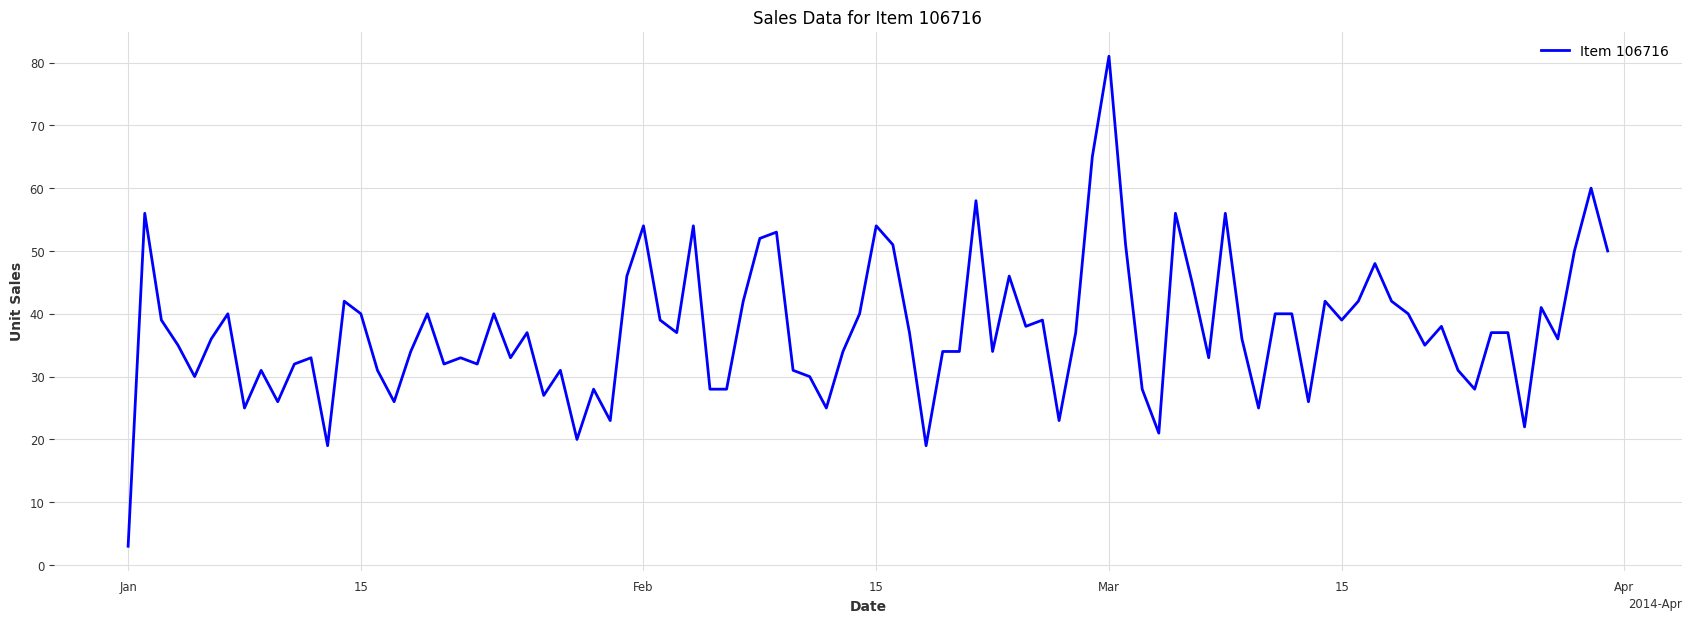

The Dataframe before grouping for item 1158720:
              id       date  store_nbr  item_nbr  unit_sales  onpromotion  \
437     16324284 2014-01-01         36   1158720        28.0          0.0   
1266    16353829 2014-01-02         24   1158720        20.0          0.0   
2805    16357818 2014-01-02         27   1158720         7.0          0.0   
3634    16359202 2014-01-02         28   1158720       224.0          0.0   
4315    16360295 2014-01-02         30   1158720        35.0          0.0   
...          ...        ...        ...       ...         ...          ...   
625240  21627047 2014-03-31         30   1158720         6.0          0.0   
625808  21629218 2014-03-31         32   1158720         3.0          0.0   
626624  21631499 2014-03-31         34   1158720        68.0          0.0   
627280  21632526 2014-03-31         35   1158720        40.0          0.0   
628052  21633670 2014-03-31         36   1158720        71.0          0.0   

           family  class  p

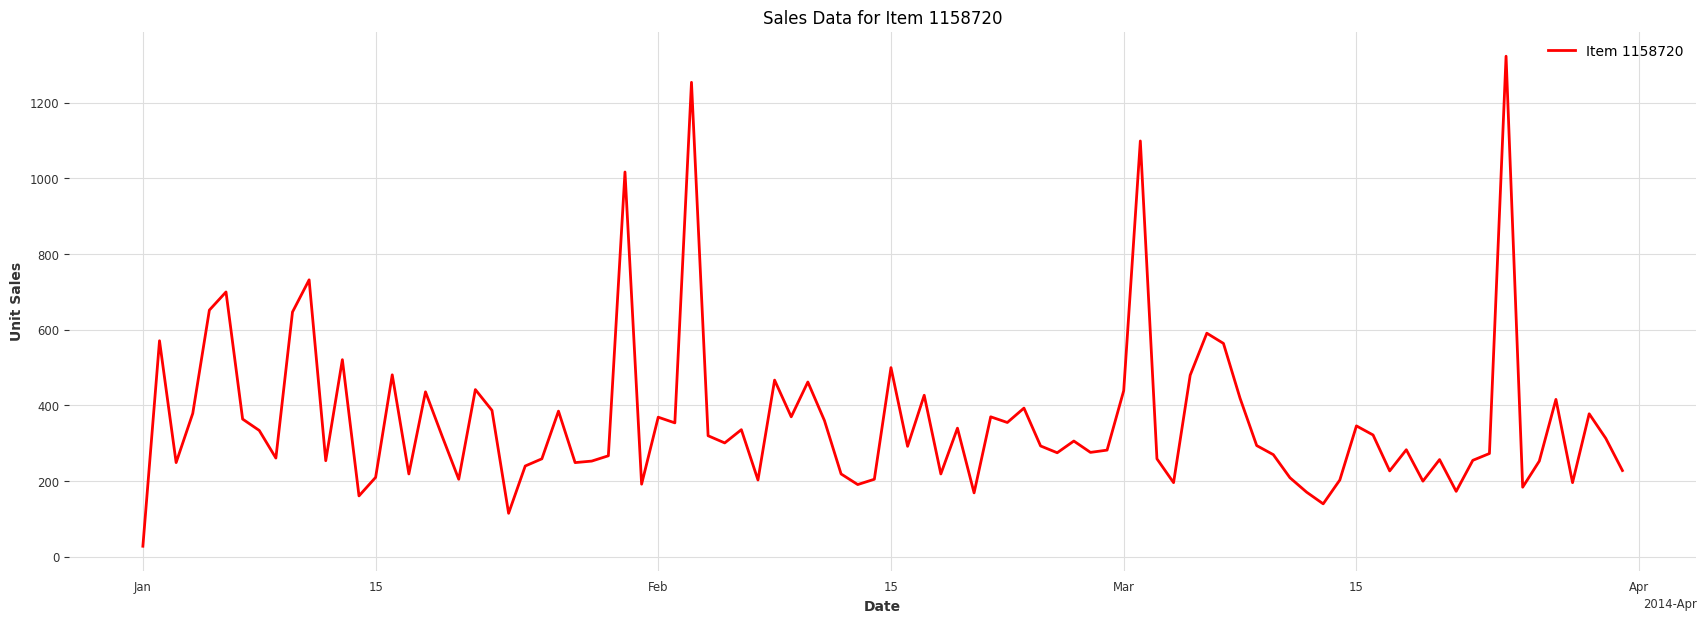

In [13]:
#Visualise TimeSeries in ein graph but with separate line for each item
import matplotlib.pyplot as plt
from darts import TimeSeries
item_ids = [106716, 1158720]
colors = ['blue', 'red']
for item_nbr, color in zip(item_ids, colors):
    #create new figure and axes for each plot.
    fig, ax = plt.subplots(figsize=(21, 7))
    df_filtered_item = df_filtered_items[df_filtered_items['item_nbr'] == item_nbr].copy()
    print(f"The Dataframe before grouping for item {item_nbr}:\n{df_filtered_item}") #add this line
    df_filtered_item['date'] = pd.to_datetime(df_filtered_item['date']) #add this line
    df_filtered_item = df_filtered_item.groupby('date')['unit_sales'].sum().reset_index()
    print(f"The Dataframe after grouping for item {item_nbr}:\n{df_filtered_item}") #add this line
    df_filtered_item.set_index('date', inplace=True)
    df_filtered_item = df_filtered_item.asfreq('D').fillna(0)
    series = TimeSeries.from_dataframe(df_filtered_item, value_cols='unit_sales')
    # Plot the series correctly
    series.plot(ax=ax, label=f'Item {item_nbr}', color=color)
    ax.set_title(f'Sales Data for Item {item_nbr}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Unit Sales')
    ax.legend()
    plt.show() # show each plot individually


## 2.4. Ensure data consistency

In [14]:
# Check for inconsistent data types
print(df_filtered_items.dtypes)

# Check for negative or unrealistic values in 'unit_sales'
print(df_filtered_items[df_filtered_items["unit_sales"] < 0])

# If negative values exist, replace them with NaN or 0
df_filtered_items["unit_sales"] = df_filtered_items["unit_sales"].apply(lambda x: max(x, 0))


id                      int64
date           datetime64[ns]
store_nbr               int64
item_nbr                int64
unit_sales            float64
onpromotion           float64
family                 object
class                   int64
perishable              int64
dtype: object
Empty DataFrame
Columns: [id, date, store_nbr, item_nbr, unit_sales, onpromotion, family, class, perishable]
Index: []


## 2.5. Handle categorical data

In [15]:
# If 'family' or other categorical columns need encoding
df_filtered_items["family"] = df_filtered_items["family"].astype("category")
df_filtered_items["family"].value_counts()

,count
family,
GROCERY I,1640


# Step 3.Exploratory Data Analysis (EDA)

Visualizing Sales Trends (Already done in previous step)
Checking for Seasonality & Trends
Moving Averages & Smoothing
Autocorrelation Analysis (ACF & PACF)
Outlier Detection

## 3.1. Check for Seasonality & Trends

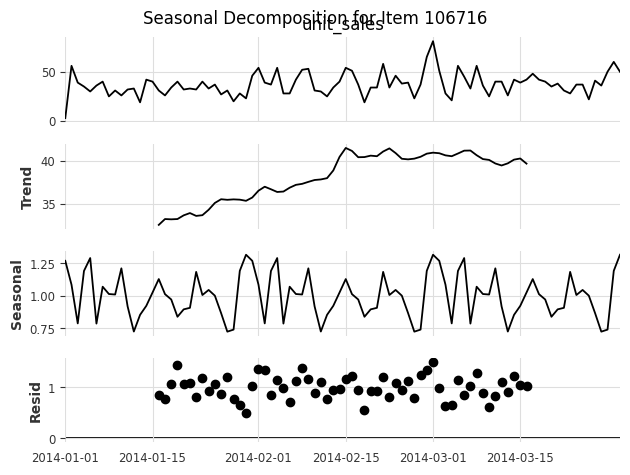

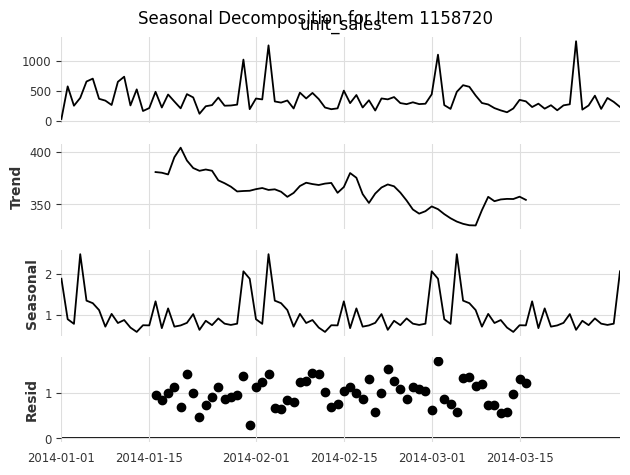

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series for each item
for item_nbr in item_ids:
    df_item = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr].copy()
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
    df_item.set_index('date', inplace=True)

    # Perform seasonal decomposition
    decomposition = seasonal_decompose(df_item['unit_sales'], model='multiplicative', period=30)

    # Plot decomposition
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition for Item {item_nbr}')
    plt.show()


Analysis of Seasonal Decomposition for Item 106716

Trend Component:
Shows a gradual increase in sales, especially in early February.
This suggests a growing demand for the product over time.

Seasonal Component:
Clear periodic fluctuations, likely on a weekly basis.
Sales tend to rise and fall in a repeating pattern.

Residual Component:
The residuals are relatively stable, meaning the model captures most patterns.
No extreme anomalies, suggesting a well-behaved time series.


Analysis of Seasonal Decomposition for Item 1158720

Trend Component:
Shows an initial decline in sales, followed by a slight recovery in early March.
This suggests a possible shift in demand or external influence affecting sales.

Seasonal Component:
Strong seasonal effects with recurring peaks, likely on a weekly or bi-weekly basis.

These spikes suggest periodic high demand, possibly due to promotions or external factors.

Residual Component:
Residuals appear more volatile compared to Item 106716.
Some strong deviations indicate potential outliers or irregular sales behavior.


## 3.2. Moving Averages & Smoothing

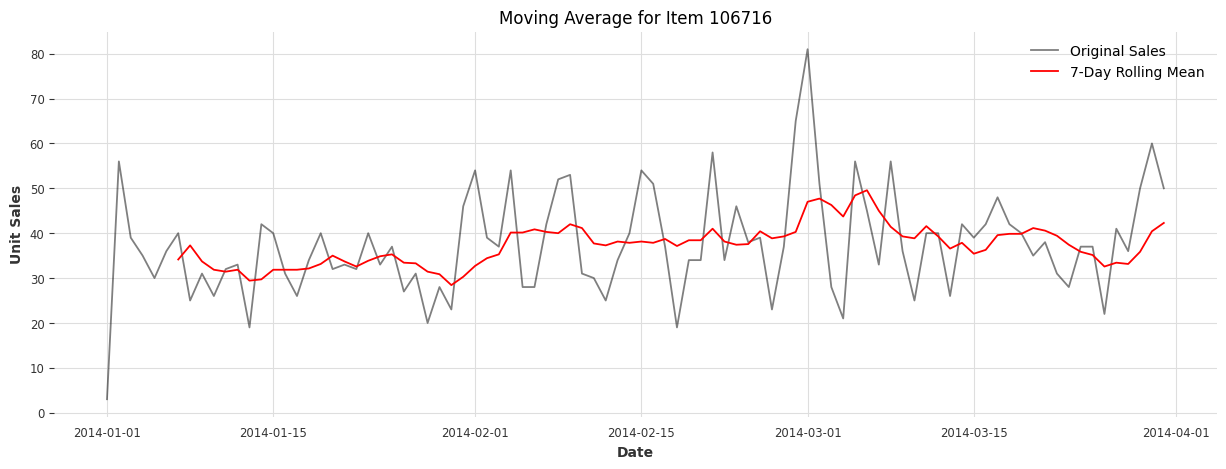

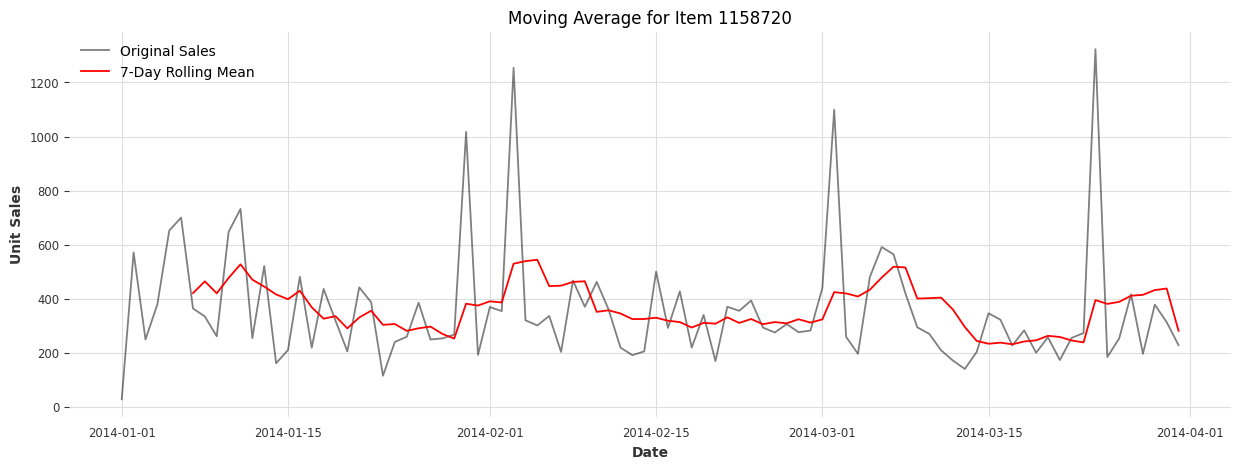

In [17]:
# Calculate rolling averages for smoothing
window_size = 7  # Weekly rolling average

for item_nbr in item_ids:
    df_item = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr].copy()
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
    df_item.set_index('date', inplace=True)

    df_item['rolling_mean'] = df_item['unit_sales'].rolling(window=window_size).mean()

    # Plot original vs smoothed data
    plt.figure(figsize=(15, 5))
    plt.plot(df_item.index, df_item['unit_sales'], label='Original Sales', alpha=0.5)
    plt.plot(df_item.index, df_item['rolling_mean'], label=f'{window_size}-Day Rolling Mean', color='red')
    plt.title(f'Moving Average for Item {item_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()


Analysis of Moving Averages for Items 106716 & 1158720
Item 106716 (First Plot)

Sales Volatility:
Sales fluctuate frequently, but remain within a reasonable range.
There are clear spikes and drops, possibly linked to promotions or seasonal trends.
7-Day Rolling Mean:
The red line follows the overall trend but smooths out short-term fluctuations.
It suggests moderate seasonality but also shows sudden shifts in demand.
Item 1158720 (Second Plot)

Sales Volatility:
This item has much larger spikes compared to item 106716.
The sales pattern is more erratic, with extreme peaks and troughs.
7-Day Rolling Mean:
The rolling average captures the general trend but lags behind sharp sales jumps.
Suggests that demand might be influenced by external events (e.g., promotions, supply constraints).

3.3. Autocorrelation Analysis (ACF & PACF)

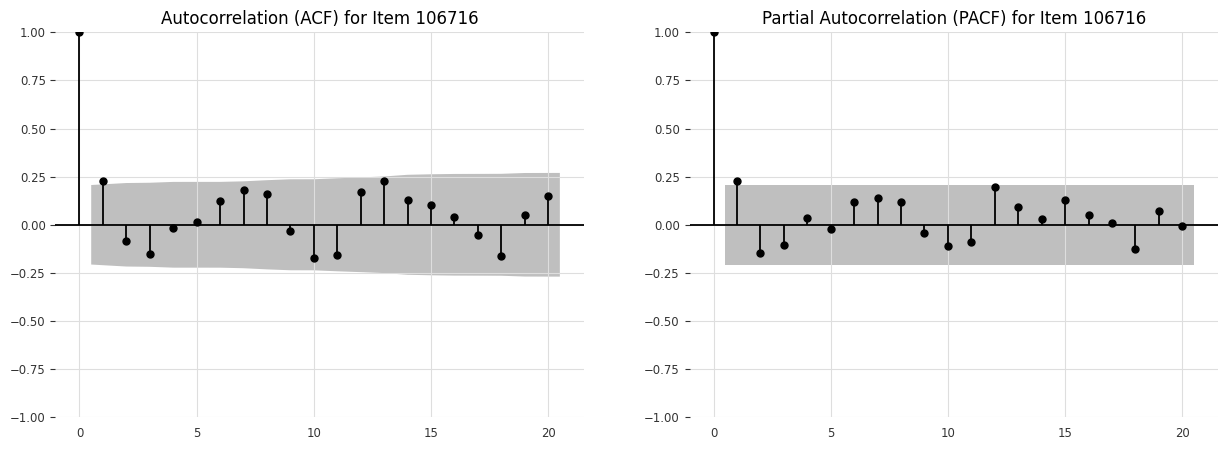

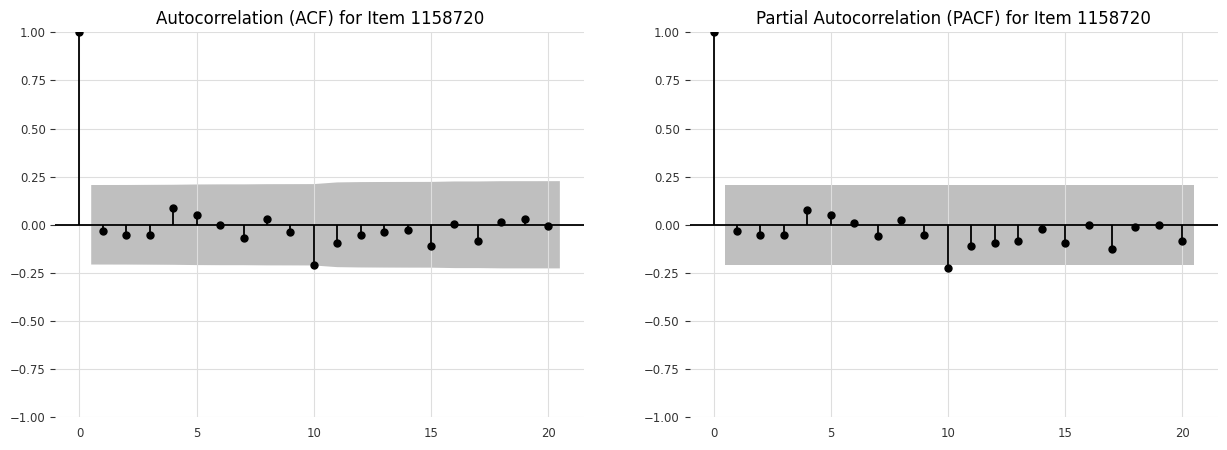

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for item_nbr in item_ids:
    df_item = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr].copy()
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
    df_item.set_index('date', inplace=True)

    # Plot ACF & PACF
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(df_item['unit_sales'], ax=axes[0])
    plot_pacf(df_item['unit_sales'], ax=axes[1])

    axes[0].set_title(f'Autocorrelation (ACF) for Item {item_nbr}')
    axes[1].set_title(f'Partial Autocorrelation (PACF) for Item {item_nbr}')
    plt.show()


Analysis of ACF & PACF for Items 106716 & 1158720


Item 106716 (First Set of Plots)

Autocorrelation Function (ACF):

Lag values show small but consistent correlations up to lag 10-12.
There is no clear seasonal pattern, meaning simple differencing might be enough.

Partial Autocorrelation Function (PACF):
A significant spike at lag 1, suggesting an AR(1) component.
Gradual decay indicates some dependence on past values but not very strong.
✅ Suggested Model: ARIMA(1,1,0) or ARIMA(1,1,1) (since PACF cuts off quickly).
✅ If seasonality needs to be accounted for, SARIMA with a weekly period might help.

Item 1158720 (Second Set of Plots)

Autocorrelation Function (ACF):
Low correlations at almost all lags, indicating weak seasonality.
The slight dip at lag 10 suggests a potential cycle.

Partial Autocorrelation Function (PACF):
Similar to ACF, with minor spikes around lags 2-3 and 10.

No clear strong autoregressive pattern.
✅ Suggested Model: ARIMA(2,1,0) or ARIMA(2,1,1) (since PACF suggests weak AR terms).
✅ If volatility is high, XGBoost with additional features (promotions, holidays, transactions) might be a better fit.

## 3.4. Outlier Detection

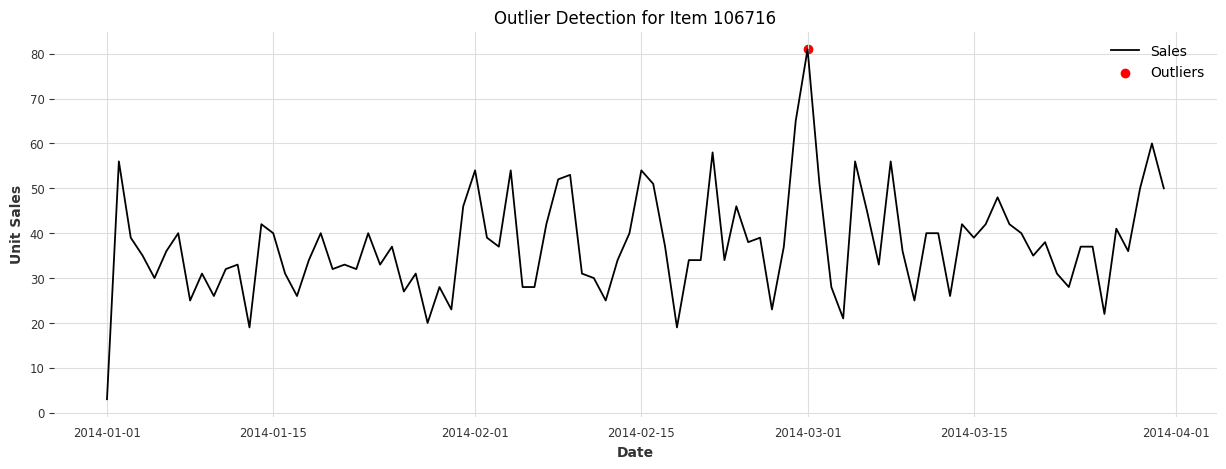

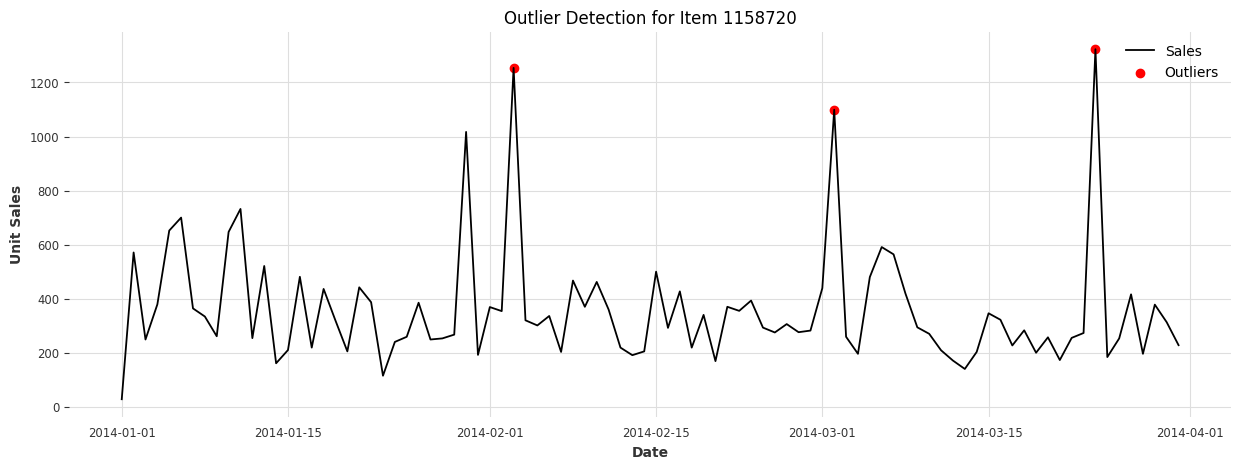

In [19]:
import numpy as np

for item_nbr in item_ids:
    df_item = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr].copy()
    df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
    df_item.set_index('date', inplace=True)

    # Define outliers as points beyond 3 standard deviations
    mean_sales = df_item['unit_sales'].mean()
    std_sales = df_item['unit_sales'].std()
    outliers = df_item[(df_item['unit_sales'] > mean_sales + 3 * std_sales) |
                       (df_item['unit_sales'] < mean_sales - 3 * std_sales)]

    # Plot sales with outliers highlighted
    plt.figure(figsize=(15, 5))
    plt.plot(df_item.index, df_item['unit_sales'], label='Sales')
    plt.scatter(outliers.index, outliers['unit_sales'], color='red', label='Outliers')
    plt.title(f'Outlier Detection for Item {item_nbr}')
    plt.xlabel('Date')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.show()


Analysis of Outlier Detection for Items 106716 & 1158720

Item 106716 (First Plot)

One major outlier detected (early March 2014).
This spike is significantly higher than the general trend, likely due to a promotion, special event, or data issue.
Sales return to normal levels afterward, suggesting it was a temporary effect.

Item 1158720 (Second Plot)

Multiple extreme spikes identified (early February & early March 2014).
These outliers are much larger than typical sales fluctuations, possibly indicating promotional campaigns, seasonal demand, or external influences.

The high volatility in this item suggests it might be more affected by external factors compared to Item 106716.

###  Investigate Outliers & Check Alignment with Promotions/Holidays

In [22]:
df_holidays_events

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [25]:
outliers.shape

(3, 1)

In [36]:
# Convert 'date' column to datetime format
df_filtered_items["date"] = pd.to_datetime(df_filtered_items["date"])
df_holidays_events["date"] = pd.to_datetime(df_holidays_events["date"])
df_transactions["date"] = pd.to_datetime(df_transactions["date"])
#Filter df_transactions for sores for store_ids in Guayas region

store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()
df_transactions_filtered = df_transactions[df_transactions["store_nbr"].isin(store_ids)]

# Aggregate transactions at the daily level
df_daily_transactions = df_transactions_filtered.groupby('date', as_index=False)['transactions'].sum()

# Merge with holidays
df_holidays_events = df_holidays_events.merge(df_daily_transactions, on="date", how="left")


# Identify outliers (3 standard deviations above mean)
for item_nbr in item_ids:
    df_item = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr].copy()

    # Aggregate sales at the daily level
    df_item = df_item.groupby('date', as_index=False)['unit_sales'].sum()

    mean_sales = df_item["unit_sales"].mean()
    std_sales = df_item["unit_sales"].std()

    # Identify outliers
    outliers = df_item[df_item["unit_sales"] > mean_sales + 3 * std_sales]

    # Merge with promotions (fixing issue with missing 'item_nbr')
    outliers = outliers.merge(
        df_filtered_items[df_filtered_items["item_nbr"] == item_nbr][["date", "onpromotion"]],
        on="date",
        how="left"
    )

    # Merge with holidays
    outliers = outliers.merge(df_holidays_events[["date", "type"]], on="date", how="left")

    # Merge with store transactions
    outliers = outliers.merge(df_daily_transactions, on="date", how="left")
    outliers = outliers.drop_duplicates(subset=['date'])

    print(f"Outliers for Item {item_nbr}:")
    print(outliers)



Outliers for Item 106716:
        date  unit_sales  onpromotion type  transactions
0 2014-03-01        81.0          0.0  NaN         17269
Outliers for Item 1158720:
         date  unit_sales  onpromotion     type  transactions
0  2014-02-03      1254.0          0.0      NaN         12976
9  2014-03-02      1099.0          0.0  Holiday         13470
19 2014-03-24      1323.0          0.0      NaN         12200


Differentiate Between Holiday and Non-Holiday Outliers
Since one outlier occurs on a holiday, while others do not, we need to handle them differently:

For the holiday outlier (March 2, 2014) → Keep it but add a holiday flag.
For other outliers (February 3 & March 24, 2014) → Cap them to Mean + 3 Std if they are not caused by promotions or other known events.

Decide on Preprocessing Strategy for Outliers

In [73]:
#  Create a Holiday Flag
df_filtered_items["holiday_flag"] = 0
df_filtered_items.loc[df_filtered_items["date"].isin(df_holidays_events["date"]), "holiday_flag"] = 1

# Calculate Mean + 3 Std for Non-Holiday Outliers
for item_nbr in item_ids:
    mean_sales = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr]["unit_sales"].mean()
    std_sales = df_filtered_items[df_filtered_items["item_nbr"] == item_nbr]["unit_sales"].std()
    cap_value = mean_sales + 3 * std_sales

    # Apply Capping ONLY to Non-Holiday Outliers
    df_filtered_items.loc[
        (df_filtered_items["item_nbr"] == item_nbr) &
        (df_filtered_items["unit_sales"] > cap_value) &
        (df_filtered_items["date"].isin(outliers[outliers["type"].isna()]["date"])),
        "unit_sales"
    ] = cap_value

# Mark Outliers in the Dataset
df_filtered_items["outlier_flag"] = 0
df_filtered_items.loc[df_filtered_items["date"].isin(outliers["date"]), "outlier_flag"] = 1


In [76]:
df_filtered_items[["outlier_flag", "holiday_flag"]].value_counts()

outlier_flag  holiday_flag
0             0               1549
              1                 37
1             0                 34
              1                 20
Name: count, dtype: int64

In [77]:
df_filtered_items.groupby("outlier_flag")["unit_sales"].describe()


,count,mean,std,min,25%,50%,75%,max
outlier_flag,,,,,,,,
0,1586.0,20.113528,43.654194,1.0,3.0,6.0,18.0,827.0
1,54.0,44.168274,123.897230,1.0,3.0,7.5,23.0,830.0


In [79]:
df_filtered_items[df_filtered_items["outlier_flag"] == 1]


,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,holiday_flag
234935,18387675,2014-02-03,24,1158720,7.000000,0.0,GROCERY I,1040,0,1,0
235002,18388777,2014-02-03,26,106716,8.000000,0.0,GROCERY I,1032,0,1,0
235538,18389532,2014-02-03,26,1158720,2.000000,0.0,GROCERY I,1040,0,1,0
235592,18389658,2014-02-03,27,106716,2.000000,0.0,GROCERY I,1032,0,1,0
236231,18390615,2014-02-03,27,1158720,17.000000,0.0,GROCERY I,1040,0,1,0
236289,18390770,2014-02-03,28,106716,1.000000,0.0,GROCERY I,1032,0,1,0
236964,18391682,2014-02-03,28,1158720,276.043404,0.0,GROCERY I,1040,0,1,0
237011,18391805,2014-02-03,30,106716,1.000000,0.0,GROCERY I,1032,0,1,0
237516,18392455,2014-02-03,30,1158720,72.000000,0.0,GROCERY I,1040,0,1,0
238022,18394161,2014-02-03,32,1158720,10.000000,0.0,GROCERY I,1040,0,1,0


In [78]:
df_filtered_items.shape

(1640, 11)

In [80]:
df_filtered_items.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,family,class,perishable,outlier_flag,holiday_flag
3,16323662,2014-01-01,36,106716,3.0,0.0,GROCERY I,1032,0,0,1
437,16324284,2014-01-01,36,1158720,28.0,0.0,GROCERY I,1040,0,0,1
554,16352784,2014-01-02,24,106716,2.0,0.0,GROCERY I,1032,0,0,0
1266,16353829,2014-01-02,24,1158720,20.0,0.0,GROCERY I,1040,0,0,0
1447,16355696,2014-01-02,26,106716,8.0,0.0,GROCERY I,1032,0,0,0


#Step 4. Feature engeneering

## 4.1. Expanding Mean (Expanding Average)

In [81]:
df_filtered_items["expanding_mean"] = df_filtered_items.groupby("item_nbr")["unit_sales"].expanding().mean().reset_index(level=0, drop=True)


##  4.2. Additional Features:

In [86]:
#Lag Features (e.g., sales from the past week, month):
df_filtered_items["lag_1"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(1)
df_filtered_items["lag_2"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(2)
df_filtered_items["lag_5"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(7)
df_filtered_items["lag_7"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(7)
df_filtered_items["lag_10"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(30)
df_filtered_items["lag_12"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(90)
df_filtered_items["lag_30"] = df_filtered_items.groupby("item_nbr")["unit_sales"].shift(30)


In [87]:
#Rolling Standard Deviation (captures sales volatility):
df_filtered_items["rolling_std_7"] = df_filtered_items.groupby("item_nbr")["unit_sales"].rolling(7).std().reset_index(level=0, drop=True)


In [88]:
#Rolling mean
df_filtered_items["rolling_mean_7"] = df_filtered_items.groupby("item_nbr")["unit_sales"].rolling(7).mean().reset_index(level=0, drop=True)

In [89]:
#Expanding mean:
df_filtered_items["expanding_mean"] = df_filtered_items.groupby("item_nbr")["unit_sales"].expanding().mean().reset_index(level=0, drop=True)

In [90]:
outliers

,date,unit_sales,onpromotion,type,transactions
0,2014-02-03,1254.0,0.0,NaN,12976
9,2014-03-02,1099.0,0.0,Holiday,13470
19,2014-03-24,1323.0,0.0,NaN,12200


In [93]:
#Merge Oil Prices Data
# Convert 'date' column to datetime format
df_oil["date"] = pd.to_datetime(df_oil["date"])

# Merge oil prices with the filtered dataset
df_filtered_items = df_filtered_items.merge(df_oil, on="date", how="left")

# Fill missing oil prices using forward fill (assuming missing values are due to non-trading days)
df_filtered_items["dcoilwtico"].fillna(method="ffill", inplace=True)


<ipython-input-93-9ee81fd93efd>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_filtered_items["dcoilwtico"].fillna(method="ffill", inplace=True)
<ipython-input-93-9ee81fd93efd>:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filtered_items["dcoilwtico"].fillna(method="ffill", inplace=True)


In [97]:
df_filtered_items.head().T

,0,1,2,3,4
id,16323662,16324284,16352784,16353829,16355696
date,2014-01-01 00:00:00,2014-01-01 00:00:00,2014-01-02 00:00:00,2014-01-02 00:00:00,2014-01-02 00:00:00
store_nbr,36,36,24,24,26
item_nbr,106716,1158720,106716,1158720,106716
unit_sales,3.0,28.0,2.0,20.0,8.0
onpromotion,0.0,0.0,0.0,0.0,0.0
family,GROCERY I,GROCERY I,GROCERY I,GROCERY I,GROCERY I
class,1032,1040,1032,1040,1032
perishable,0,0,0,0,0
outlier_flag,0,0,0,0,0


#Step 5. Stationarity

In [98]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, item_nbr):
    result = adfuller(series.dropna())
    print(f"\nADF Test for Item {item_nbr}:")
    print(f"Test Statistic: {result[0]}")
    print(f"P-Value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")

# Run stationarity test for each item
for item_nbr in item_ids:
    check_stationarity(df_filtered_items[df_filtered_items["item_nbr"] == item_nbr]["unit_sales"], item_nbr)



ADF Test for Item 1158720:
Test Statistic: -8.343363798591886
P-Value: 3.132551058936045e-13
Stationary


# Step 6. Save the Processed Dataset to CSV

In [100]:
# Save the final dataset
df_filtered_items.to_csv("/content/final_preprocessed_data.csv", index=False)
print("Final dataset saved successfully!")


Final dataset saved successfully!


**NEXT FILE NAME IS: Guayas_ARIMA_SARIMA_SARIMAX_models.ipynb**

# HERE IS ONLY PROBA TO FIT ARIMA BUT FOR THE NEXT STEP GO TO THE OTHER COLAB FILE Guayas_ARIMA_SARIMA_SARIMAX_models.ipynb

In [43]:
#Select one Item in one Store in “Guayas” region
#1158720
item_ids = [106716] # the item that we select

df_filtered_106716 = df_train_filtered[df_train_filtered['item_nbr'].isin(item_ids)]
df_filtered_106716.shape

(818, 9)

In [44]:
#Select one Item in one Store in “Guayas” region
#1158720
item_ids = [1158720] # the item that we select

df_filtered_1158720 = df_train_filtered[df_train_filtered['item_nbr'].isin(item_ids)]
df_filtered_1158720.shape

(822, 9)

In [45]:
#to convert the 'date' column to the date-time type and aggregate sales by date, replacing zero sales
# Reset index to make sure 'date' is still a column
df_filtered_106716 = df_filtered_106716.reset_index()

df_filtered_106716['date'] = pd.to_datetime(df_filtered_106716['date'])
df_filtered_106716 = df_filtered_106716.groupby('date').sum()['unit_sales'].reset_index()


# Setting an index after the aggregation made
df_filtered_106716.set_index('date', inplace=True)

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered_106716 = df_filtered_106716.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series_106716 = TimeSeries.from_dataframe(df_filtered_106716, value_cols='unit_sales')

In [46]:
#to convert the 'date' column to the date-time type and aggregate sales by date, replacing zero sales
# Reset index to make sure 'date' is still a column
df_filtered_1158720 = df_filtered_1158720.reset_index()

df_filtered_1158720['date'] = pd.to_datetime(df_filtered_1158720['date'])
df_filtered_1158720 = df_filtered_1158720.groupby('date').sum()['unit_sales'].reset_index()


# Setting an index after the aggregation made
df_filtered_1158720.set_index('date', inplace=True)

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered_1158720 = df_filtered_1158720.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series_1158720 = TimeSeries.from_dataframe(df_filtered_1158720, value_cols='unit_sales')

In [ ]:
# Aggregate data by date
daily_sales_1158720 = df_filtered_1158720.groupby('date')['unit_sales'].sum()

# Decompose the time series with a weekly period
decomposition_1158720 = seasonal_decompose(daily_sales_1158720, model='additive', period=7)

# Plot the components
plt.figure(figsize=(12, 8))
decomposition_1158720.plot()
plt.show()

In [48]:
from statsmodels.tsa.stattools import adfuller

# Aggregate total sales by date
sales_by_date_106716 = df_filtered_106716.groupby('date')['unit_sales'].sum()

# Perform the Augmented Dickey-Fuller (ADF) test
adf_test_106716 = adfuller(sales_by_date_106716)

# Print results
print("📉 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_test_106716[0]:.4f}")
print(f"p-value: {adf_test_106716[1]:.4f}")
print(f"Critical Values: {adf_test_106716[4]}")

# Interpretation
if adf_test_106716[1] < 0.05:
    print("✅ The data is stationary (Reject H₀)")
else:
    print("❌ The data is non-stationary (Fail to Reject H₀)")


📉 Augmented Dickey-Fuller Test Results:
ADF Statistic: -6.4375
p-value: 0.0000
Critical Values: {'1%': -3.506944401824286, '5%': -2.894989819214876, '10%': -2.584614550619835}
✅ The data is stationary (Reject H₀)


In [49]:
# Aggregate total sales by date
sales_by_date_1158720 = df_filtered_1158720.groupby('date')['unit_sales'].sum()

# Perform the Augmented Dickey-Fuller (ADF) test
adf_test_1158720 = adfuller(sales_by_date_1158720)

# Print results
print("📉 Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_test_1158720[0]:.4f}")
print(f"p-value: {adf_test_1158720[1]:.4f}")
print(f"Critical Values: {adf_test_1158720[4]}")

# Interpretation
if adf_test_1158720[1] < 0.05:
    print("✅ The data is stationary (Reject H₀)")
else:
    print("❌ The data is non-stationary (Fail to Reject H₀)")

📉 Augmented Dickey-Fuller Test Results:
ADF Statistic: -9.7225
p-value: 0.0000
Critical Values: {'1%': -3.506057133647011, '5%': -2.8946066061911946, '10%': -2.5844100201994697}
✅ The data is stationary (Reject H₀)


## 1.5. Splitting the Data into Training and Testing Sets

In [50]:
# Split the data (80% training, 20% testing)
train_106716, test_106716 = series_106716.split_after(0.8)
train_1158720, test_1158720 = series_1158720.split_after(0.8)

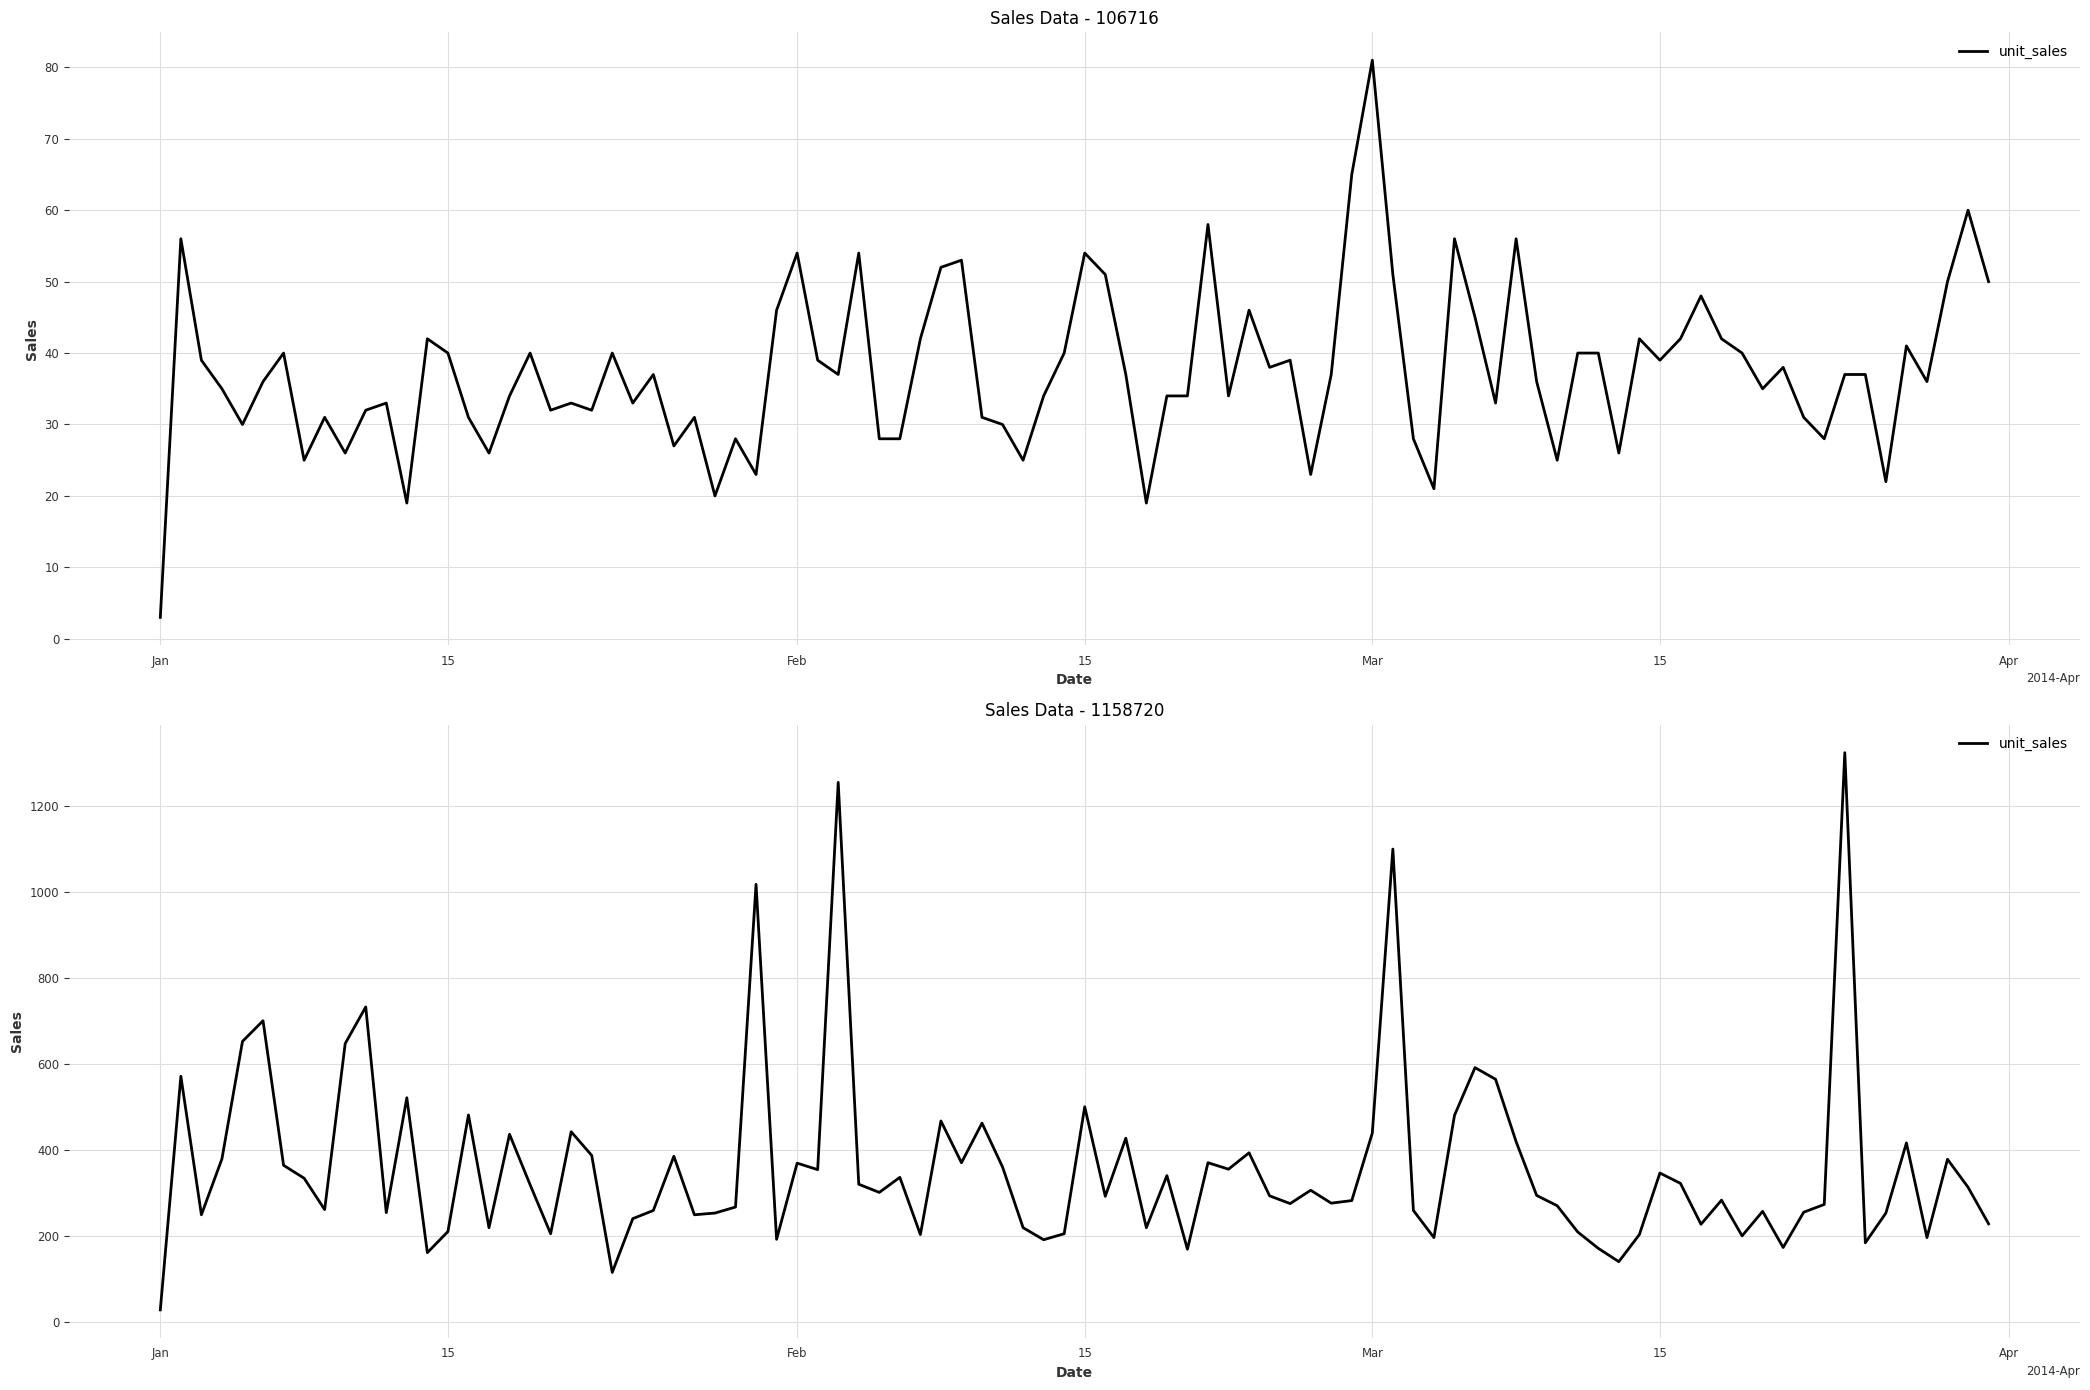

In [51]:
# Visualize the filtered sales data
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

# Create a figure with two subplots (2 rows, 1 column)
plt.figure(figsize=(21, 14))  # Adjust the figure size (width, height)

# Plot for series_106716 (top plot)
plt.subplot(2, 1, 1)  # (rows, columns, index)
series_106716.plot()
plt.title('Sales Data - 106716')
plt.xlabel('Date')
plt.ylabel('Sales')

# Plot for series_1158720 (bottom plot)
plt.subplot(2, 1, 2)  # (rows, columns, index)
series_1158720.plot()
plt.title('Sales Data - 1158720')
plt.xlabel('Date')
plt.ylabel('Sales')

# Show the plots
plt.tight_layout()  # Adjust the spacing between subplots
plt.show()



## 1.6. Fit model ARIMA

In [18]:
pip install dask

In [70]:
from darts.models import ARIMA

# Initialize ARIMA model with (p, d, q) parameters
arima_model_106716 = ARIMA(p=12, d=1, q=0)
arima_model_1158720 = ARIMA(p=5, d=1, q=0)

We initialize an ARIMA model with an order of (5, 1, 0), which means:
p=5: We are using 5 previous observations (autoregressive terms).
d=1: The data is differenced once to make it stationary.
q=0: No moving average terms are used.
p, d and q can significantly impact the way the model is performed, so selecting them properly is the key. The best way to select these three parameters is via ACF and PACF charts!

train_106716, test_106716 = series_106716.split_after(0.8)
train_1158720, test_1158720 = series_1158720.split_after(0.8)

Mean Absolute Error (MAE): 7.903103443904064
Mean Squared Error (MSE): 99.867094666235
Root Mean Squared Error (RMSE): 9.993352523864802
Mean Absolute Percentage Error (MAPE): 0.19728729632825712


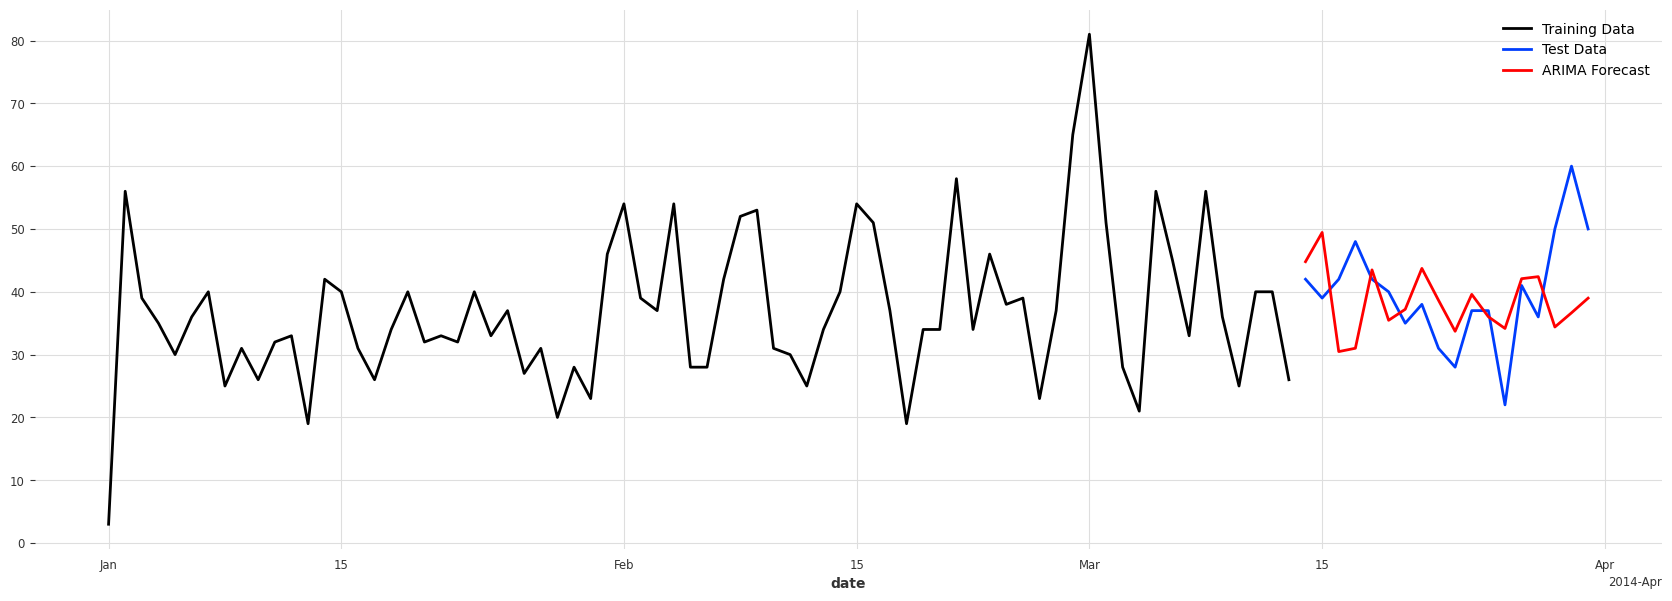

In [118]:
# Fit the ARIMA model on the training data
arima_model_106716=arima_model_106716.fit(train_106716)

# Forecast the next values (the same length as the test set)
arima_forecast_106716 = arima_model_106716.predict(len(test_106716))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train_106716.plot(label='Training Data')
test_106716.plot(label='Test Data')
arima_forecast_106716.plot(label='ARIMA Forecast', color='red')

# Calculate error metrics, converting TimeSeries to NumPy arrays
test_values_106716 = test_106716.values().flatten() #convert to array
forecast_values_106716 = arima_forecast_106716.values().flatten() #convert to array

mae_106716 = mean_absolute_error(test_values_106716, forecast_values_106716)
mse_106716 = mean_squared_error(test_values_106716, forecast_values_106716)
rmse_106716 = np.sqrt(mse_106716)
mape_106716 = mean_absolute_percentage_error(test_values_106716, forecast_values_106716)

print(f"Mean Absolute Error (MAE): {mae_106716}")
print(f"Mean Squared Error (MSE): {mse_106716}")
print(f"Root Mean Squared Error (RMSE): {rmse_106716}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_106716}")


Mean Absolute Error (MAE): 128.50997261253426
Mean Squared Error (MSE): 76289.19441918275
Root Mean Squared Error (RMSE): 276.20498623157175
Mean Absolute Percentage Error (MAPE): 0.2714341380425771


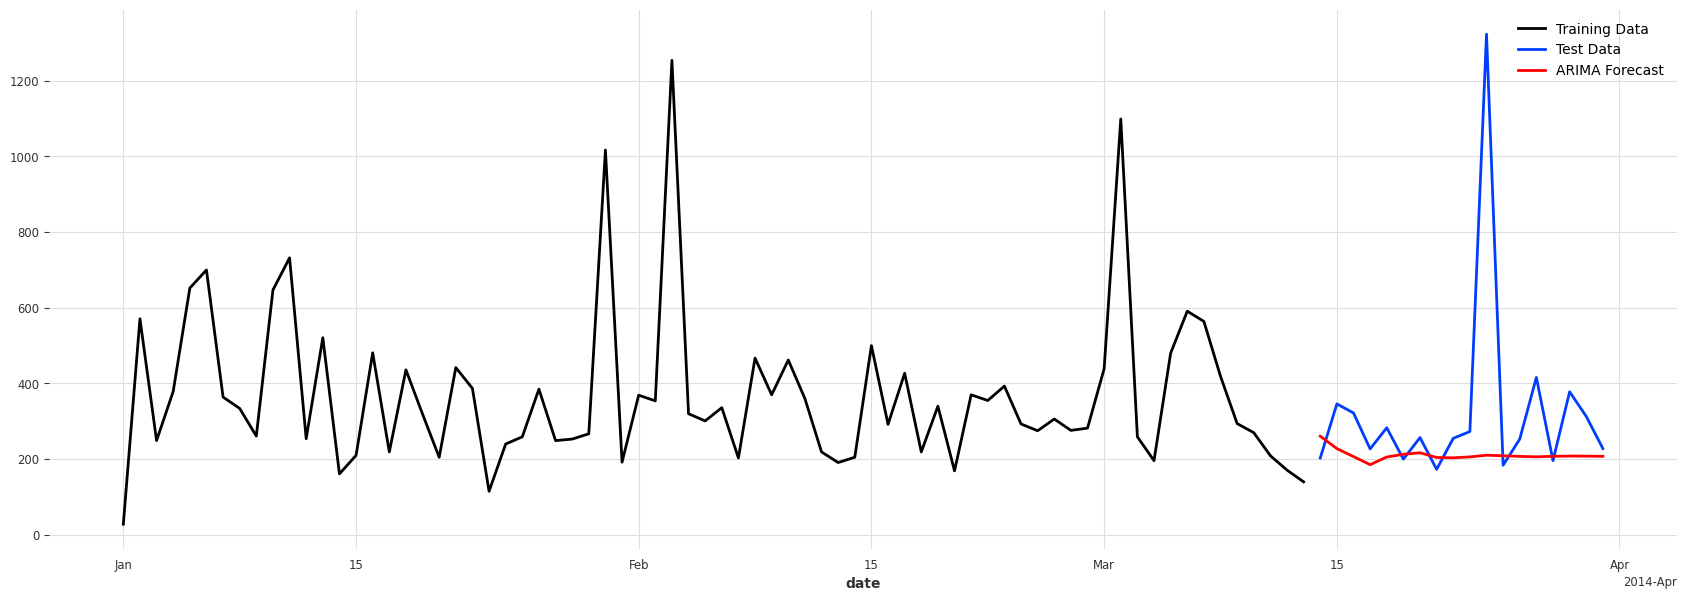

In [121]:
# Fit the ARIMA model on the training data
arima_model_1158720=arima_model_1158720.fit(train_1158720)

# Forecast the next values (the same length as the test set)
arima_forecast_1158720 = arima_model_1158720.predict(len(test_1158720))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train_1158720.plot(label='Training Data')
test_1158720.plot(label='Test Data')
arima_forecast_1158720.plot(label='ARIMA Forecast', color='red')

# Calculate error metrics, converting TimeSeries to NumPy arrays
test_values_1158720 = test_1158720.values().flatten() #convert to array
forecast_values_1158720 = arima_forecast_1158720.values().flatten() #convert to array

#Remove the mean import from sklearn.metrics because you do not use it
mae_1158720 = mean_absolute_error(test_values_1158720, forecast_values_1158720) #apply the array conversion
mse_1158720 = mean_squared_error(test_values_1158720, forecast_values_1158720) #apply the array conversion
rmse_1158720 = np.sqrt(mse_1158720)
mape_1158720 = mean_absolute_percentage_error(test_values_1158720, forecast_values_1158720) #apply the array conversion

print(f"Mean Absolute Error (MAE): {mae_1158720}")
print(f"Mean Squared Error (MSE): {mse_1158720}")
print(f"Root Mean Squared Error (RMSE): {rmse_1158720}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_1158720}")


## 1.7. Fit the model **SARIMA**

Shortcomings of ARIMA and SARIMA Methods:
While ARIMA and SARIMA are powerful time-series forecasting techniques, they have some limitations:
Stationarity Requirement: Both ARIMA and SARIMA assume that the data is stationary, meaning that its statistical properties (like mean and variance) do not change over time. This often requires transforming or differencing the data, which can be challenging for complex, non-linear series.
Limited Non-Linearity Handling: ARIMA and SARIMA are linear models, meaning they may struggle to capture complex non-linear relationships in the data.
Seasonality Issues: SARIMA can handle seasonality, but only if it is consistent and well-defined. If seasonality changes over time or if there are multiple seasonal patterns, SARIMA might not perform well.
High Computational Cost for Large Data: Fitting ARIMA or SARIMA models can be computationally expensive when dealing with large datasets or long time series, as the models need to iterate over many lags.
No Exogenous Variables Support in Basic ARIMA/SARIMA: While ARIMA and SARIMA can model the data based on its own past values, they do not easily incorporate external influences (exogenous variables) unless you use extensions like ARIMAX.
There are many other classical methods, which don’t have such shortcomings, e.g Exponential Smoothing  or ARIMAX (AutoRegressive Moving Average with Exogenous Variables). We won’t cover them in our lessons, but if you would like to learn more about classical time-series methods, please check out the additional materials suggested for this week.


train_106716, test_106716 = series_106716.split_after(0.8) train_1158720, test_1158720 = series_1158720.split_after(0.8)

Mean Absolute Error (MAE): 11.631876349579398
Mean Squared Error (MSE): 207.76497332591805
Root Mean Squared Error (RMSE): 14.414054714961992
Mean Absolute Percentage Error (MAPE): 0.3143835915943209


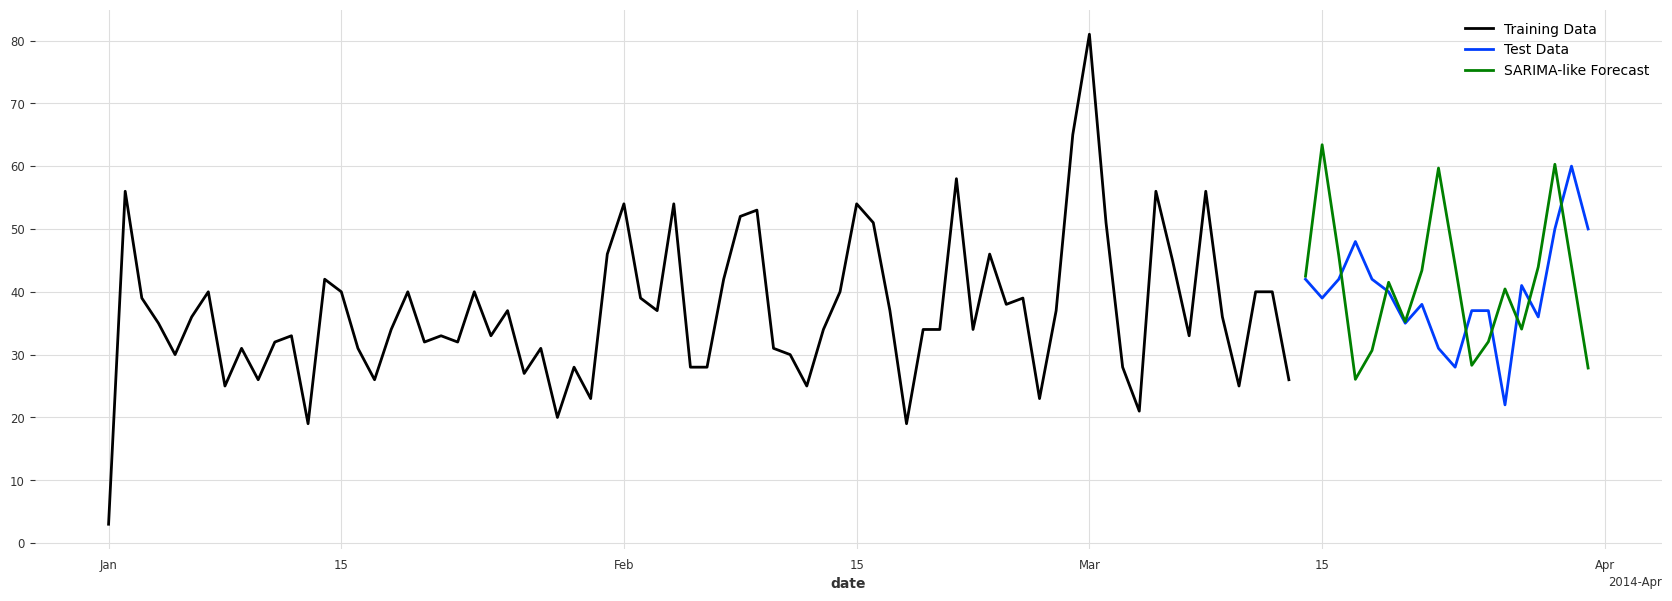

In [122]:
from darts.models import ARIMA

# Initialize ARIMA model with both (p, d, q) and (P, D, Q, m) parameters
# (P, D, Q, m) = (1, 1, 1, 7) for seasonal components (e.g., weekly seasonality)
sarima_like_model_106716 = ARIMA(p=5, d=0, q=1, seasonal_order=(1, 1, 1, 7))

# Fit the ARIMA model with seasonality on the training data
sarima_like_model_106716.fit(train_106716)

# Forecast the next values (the same length as the test set)
sarima_forecast_106716 = sarima_like_model_106716.predict(len(test_106716))

# Plot SARIMA-like forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train_106716.plot(label='Training Data')
test_106716.plot(label='Test Data')
sarima_forecast_106716.plot(label='SARIMA-like Forecast', color='green')

# Calculate error metrics, converting TimeSeries to NumPy arrays
test_values_106716 = test_106716.values().flatten() #convert to array
forecast_values_106716 = sarima_forecast_106716.values().flatten() #convert to array

mae_106716 = mean_absolute_error(test_values_106716, forecast_values_106716)
mse_106716 = mean_squared_error(test_values_106716, forecast_values_106716)
rmse_106716 = np.sqrt(mse_106716)
mape_106716 = mean_absolute_percentage_error(test_values_106716, forecast_values_106716)

print(f"Mean Absolute Error (MAE): {mae_106716}")
print(f"Mean Squared Error (MSE): {mse_106716}")
print(f"Root Mean Squared Error (RMSE): {rmse_106716}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_106716}")



/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 151.10200000621484
Mean Squared Error (MSE): 56194.62366933347
Root Mean Squared Error (RMSE): 237.05405221032075
Mean Absolute Percentage Error (MAPE): 0.46380628486893144


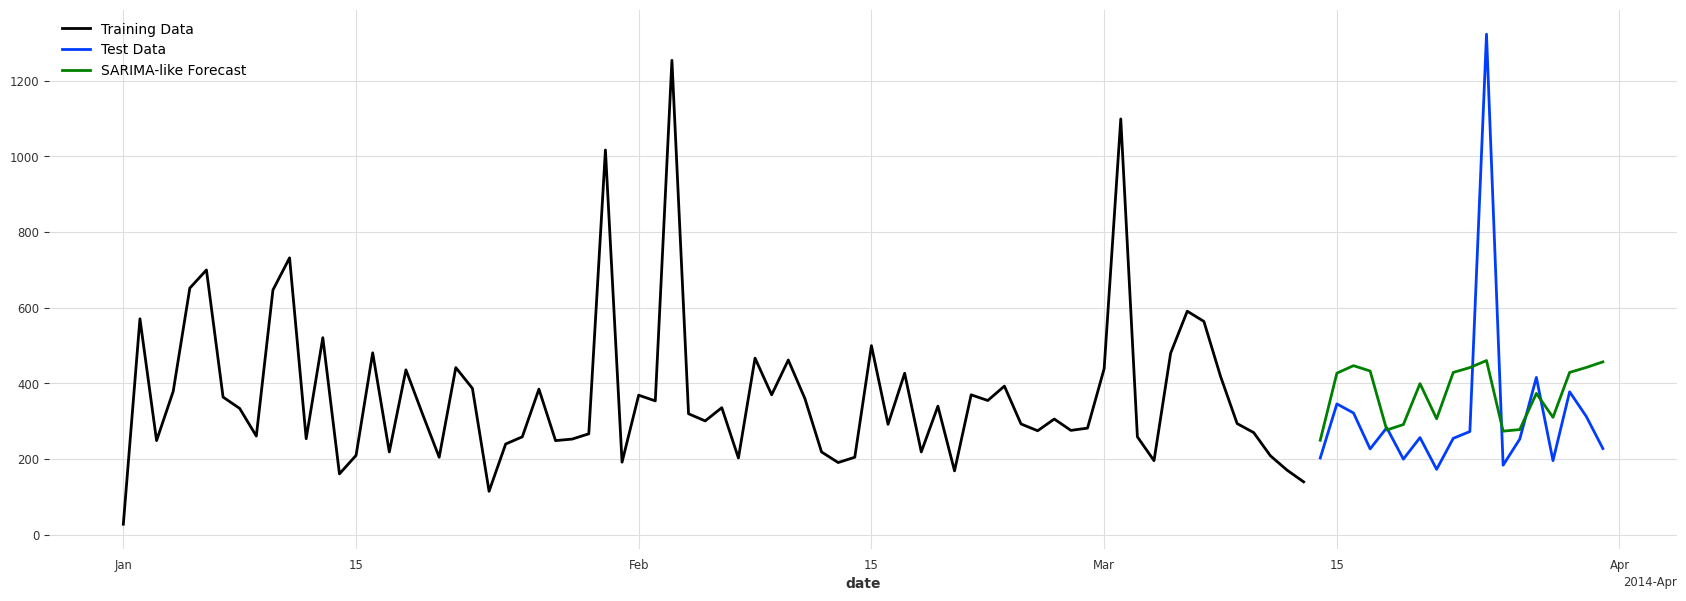

In [123]:
from darts.models import ARIMA

# Initialize ARIMA model with both (p, d, q) and (P, D, Q, m) parameters
# (P, D, Q, m) = (1, 1, 1, 7) for seasonal components (e.g., weekly seasonality)
sarima_like_model_1158720 = ARIMA(p=5, d=0, q=1, seasonal_order=(1, 1, 1, 7))

# Fit the ARIMA model with seasonality on the training data
sarima_like_model_1158720.fit(train_1158720)

# Forecast the next values (the same length as the test set)
sarima_forecast_1158720 = sarima_like_model_1158720.predict(len(test_1158720))

# Plot SARIMA-like forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train_1158720.plot(label='Training Data')
test_1158720.plot(label='Test Data')
sarima_forecast_1158720.plot(label='SARIMA-like Forecast', color='green')
# Calculate error metrics, converting TimeSeries to NumPy arrays
test_values_1158720 = test_1158720.values().flatten() #convert to array
forecast_values_1158720 = sarima_forecast_1158720.values().flatten() #convert

mae_1158720 = mean_absolute_error(test_values_1158720, forecast_values_1158720)
mse_1158720 = mean_squared_error(test_values_1158720, forecast_values_1158720)
rmse_1158720 = np.sqrt(mse_1158720)
mape_1158720 = mean_absolute_percentage_error(test_values_1158720, forecast_values_1158720)


print(f"Mean Absolute Error (MAE): {mae_1158720}")
print(f"Mean Squared Error (MSE): {mse_1158720}")
print(f"Root Mean Squared Error (RMSE): {rmse_1158720}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_1158720}")


<Axes: xlabel='date'>

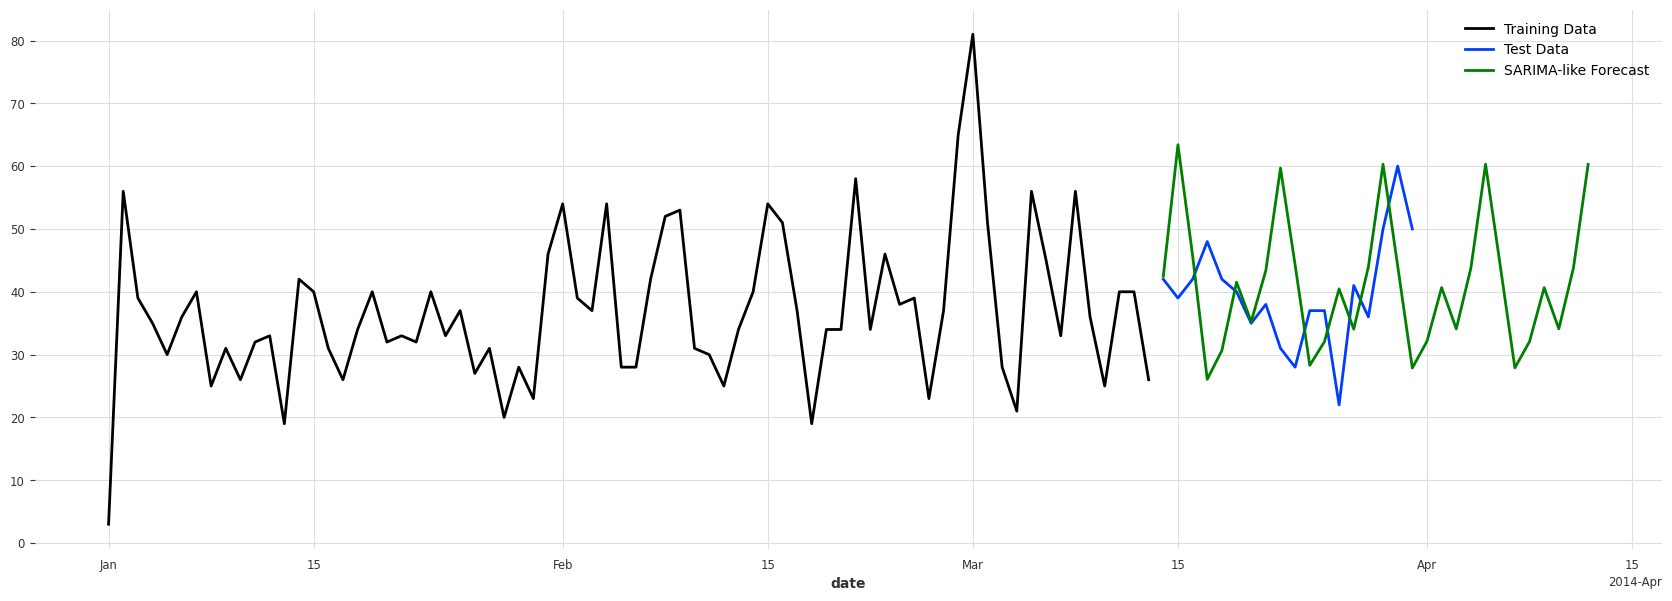

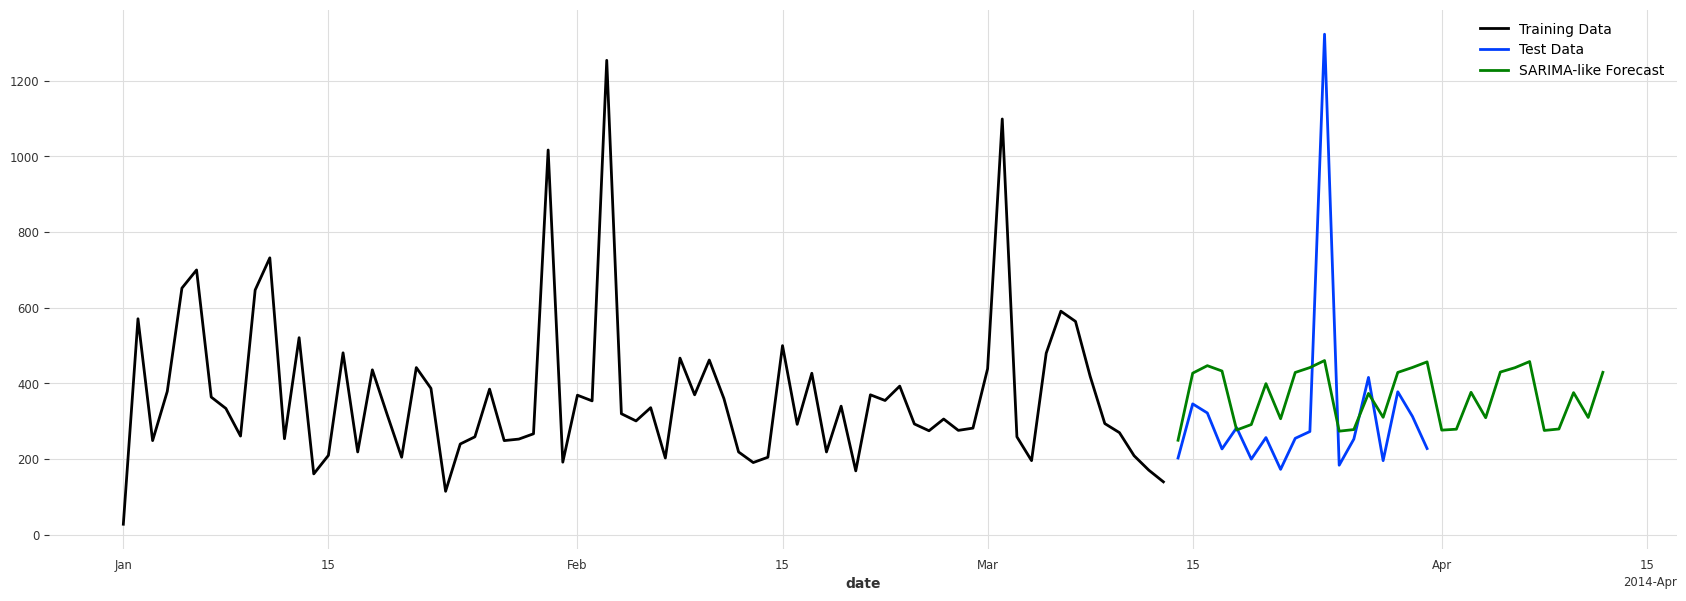

In [108]:
#Predict on the next 30 Days and visualise with all dataset sarima_like_model_106716 and sarima_like_model_1158720 and add the confidence interval

prediction_106716 = sarima_like_model_106716.predict(n=30)
prediction_1158720 = sarima_like_model_1158720.predict(n=30)

plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train_106716.plot(label='Training Data')
test_106716.plot(label='Test Data')
prediction_106716.plot(label='SARIMA-like Forecast', color='green')



plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train_1158720.plot(label='Training Data')
test_1158720.plot(label='Test Data')
prediction_1158720.plot(label='SARIMA-like Forecast', color='green')





